# Parametric projected trap array simulations
the premier high-level notebook in the projected trap array analysis. 
trap arrays can be for several configurations given a list of params,
and the simulation data can be saved with sensible names automatically.

for now, this will only handle monochromatic spatially coherent fields.

In [99]:
from matplotlib import colors
import matplotlib.pyplot as plt
from collections import namedtuple
from numpy import real
import csv

## local imports
import os,sys
sys.path.append(os.path.join("..","."))
from field_funcs import * # my helper functions

## make the display wide
from IPython.core.display import HTML, display, Image
display(HTML("<style>.container{width:100% !important;}</style>"))

# image path 
# imagedir = os.path.join('..','images')
imagedir = os.path.join('.','paper_data')
print("images saved in", imagedir)

# for matplotlib labels
fontsize=14

def savefigure(fname):
    filepath = os.path.join(imagedir,fname)
    plt.savefig(filepath, bbox_inches='tight')
    print("saved file to",filepath)
    
def saveplotdata(data):
    pass

images saved in .\paper_data


In [53]:
## physics and lens params
lmbda = 8.05e-7
k = 2*pi/lmbda
f1 = .5 # lens focal length [m]
f2 = 0.005
A0 = 1 # input field amplitude

## input mask grid params
xnum = ynum = 10 # number of grid points in each dimension
pts = 1100 # grid mesh is pts x pts

In [40]:
# Gaussian beam array object.
param_names = ['type','a1','t1','r1','dx','dy','a2','r2','phi_std','pos_std']
gba = namedtuple('gba',param_names,defaults=[None,None,None,None])

In [80]:
array = gba('bright',1e-4,0,0,4.3e-4,4.3e-4)
# name,a,t,r,dx,dy = array
array

gba(type='bright', a1=0.0001, t1=0, r1=0, dx=0.00043, dy=0.00043, a2=None, r2=None, phi_std=None, pos_std=None)

In [81]:
# reproduce standard bright array and save the image data

# list of gba configurations over which to iterate
configurations = [gba('bright',1e-4,0,0,4.3e-4,4.3e-4)] #,
#                   gba('bright_asym',1e-4,1,0,4.3e-4,4.3e-4)]

In [82]:
for i,cfg in enumerate(configurations):
    
    # extract the array params
    name,a1,t1,r1,dx,dy,a2,r2,phi_std,pos_std = [
        getattr(cfg, attr) for attr in param_names]

    # calculate the Talbot lengths
    Lx2 = f2*dx/f1 # output array periodicity
    Ly2 = f2*dy/f1
    zTalbotx = 2*Lx2**2/lmbda 
    zTalboty = 2*Ly2**2/lmbda
    b = f1*3.8317/(a1*k) # fourier plane filter radius
        
    # create the mask
    
    if name == 'bright_dark':
        
        mask, x0pts, w = spot_mask(xnum, ynum, a1, dx, dy, pts, 
                               phi_std=phi_std, pos_std=pos_std, 
                               aperture=1-r1, plate=t1)
        
        # make a plate with 0s in the background and spots = -t1, 
        # so adding this to the plate we just made will complete the 
        # bright-dark mask
        phi_std=None # [rad]
        pos_std=None
        t12 = 0 # plate transmissivity
        mask2, x0pts, w = spot_mask(xnum, ynum, a2, dx, dy, pts, 
            phi_std=phi_std, pos_std=pos_std, aperture=1-t1, plate=t12)

        # need to offset mask2
        offset_pts= int(pts/(xnum+1)/2)
        mask2_offset = zeros((pts,pts),complex)
        for i in range(pts):
            for j in range(pts):
                if i + offset_pts < pts and j + offset_pts < pts: 
                    mask2_offset[i + offset_pts,j + offset_pts] = mask2[i,j]
        
        # offset the total mask to be more centered now
        mask_total = mask + mask2_offset
        offset_final_pts = int(offset_pts/2)
        mask_total_offset = full((pts,pts),t1,complex)
        for i in range(pts):
            for j in range(pts):
                if i - offset_pts > 0 and j - offset_pts > 0: 
                    mask_total_offset[i - offset_final_pts,j - offset_final_pts] = mask_total[i,j]
        
        mask = mask_total_offset
        b = f1*3.8317/(max(a1,a2)*k)
        
        print(f'b={b:0.6f}, a_dark={a1}, a_bright={a2}, dx={dx}, dy={dy}, xnum={xnum}, ynum={ynum}')
        print(f'zTalbotx={zTalbotx:0.6f}, zTalboty={zTalboty:0.6f}')
        
    else:
        
        mask, x0pts, w = spot_mask(xnum, ynum, a1, dx, dy, pts, 
                               phi_std=phi_std, pos_std=pos_std, 
                               aperture=1-r1, plate=t1)
        
        print(f'b={b:0.6f}, a={a1}, dx={dx}, dy={dy}, xnum={xnum}, ynum={ynum}')
        print(f'zTalbotx={zTalbotx:0.6f}, zTalboty={zTalboty:0.6f}')
        
    field0 = mask
    
    # SAVE THE INPUT MASK
        
    #todo
        
    # FOURIER PLANE FIELD -- propogate the field and apply a filter in the Fourier plane
    padding = pts//2 # int(3*pts/2) #TODO set
    rr0 = sqrt(x0pts**2 + x0pts.reshape(-1,1)**2)
    field1,x1pts = lens_xform(f1,field0,b,f1,k,x0pts,rr0,padding, masked=False,
                              padval=1,logging=False)

    # OUTPUT FIELD -- propagate field in Fourier plane to z2 behind lens f2 
    rr1 = sqrt(x1pts**2 + x1pts.reshape(-1,1)**2)
    padding = pts//2

    # axial output planes to probe
    zvals = [f2, f2 + min(zTalbotx, zTalboty)]

    for z2 in zvals: 

        field2,x2pts = lens_xform(z2,field1,b,f2,k,x1pts,rr1,padding,masked=True,
                                 logging=False)

        if z2 == f2:
            focal_field = field2
        else:
            talbot_field = field2
            
print(f"step {i} completed")

b=0.002455, a=0.0001, dx=0.00043, dy=0.00043, xnum=10, ynum=10
zTalbotx=0.000046, zTalboty=0.000046
step 0 completed


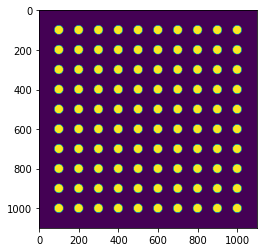

In [83]:
plt.imshow(real(mask))

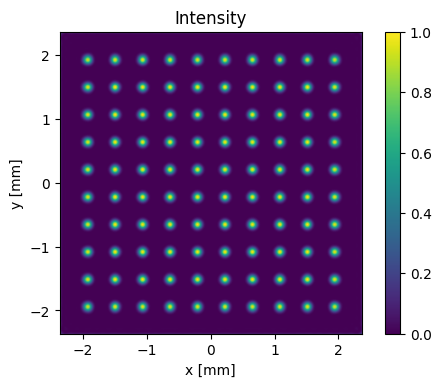

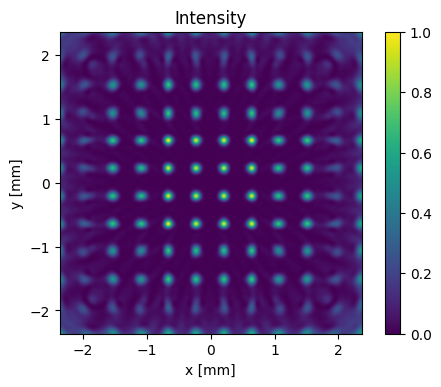

In [84]:
# SAVE OUTPUT INTENSITIES
for output_field,z2 in zip([focal_field,talbot_field],zvals):
    I2_xy = conjugate(output_field)*output_field
    if f2 - z2 == 0:
        I2xy_max = amax(I2_xy)
    I2_xy /= I2xy_max
    I2_xy = real(I2_xy)

    # plot

    fig,ax = figax(xlabel=r'x [mm]', ylabel=r'y [mm]')
    fig.dpi=100
    ax.set_title(rf'Intensity') #$t_{{spot}}$={1-r_aper:0.2f}, $t_{{plate}}$={t_plate:0.2f}',)
    mmscl = 1e3
    cax = ax.imshow(I2_xy, extent=[-w*mmscl,w*mmscl,-w*mmscl,w*mmscl])
    cax.set_norm(colors.Normalize(vmin=0, vmax=1))
    cbar = fig.colorbar(cax)

        # save intensity data as a csv



In [120]:
## functions to save array data

# only store non-complex data

def soln_to_csv(fname, data, labels, metastr=None):
    """
    Args:
        fname: myfile.csv
        data: a list or array of equal length lists or arrays of data
        labels: a label describing each list in data. None by default.
    
        e.g., 
        data = [array([1,2,3]), array([2,4,6], array([1,4,9]]
        labels = ['x', '2x', 'x^2']
    """
    
    
    if type(data) == np.ndarray:
    # listify to avoid malforming strings
        data = [d for d in data]
    
    with open(fname, 'w', newline='') as f:
        writer = csv.writer(f, delimiter=',')

        if metastr:
            writer.writerow([metastr])
        
        if labels:
            for d,l in zip(data, labels):
                writer.writerow([l] + list(d))
        
        else:
            for d in data:
                writer.writerow(d)
            
    print(f"wrote data to {fname}")

def soln_from_csv(fname, labels=True, metastr=False, datatype=complex):
    """
    Args:
        fname: myfile.csv
        labels: if True, assume the zeroth element of each row
        contains labels for the columns of data
        metastr: if True, will interpret the first row of the data as
        a string which is not part of the data. False by default
        datatype: a python datatype. complex by default
    Returns:
        data: an array of equal length arrays of data
        labels: a label describing each array in data if labels is True
        metadata: if metastr is True, a str found at the start of the file
    
        e.g. 
            data = [array([1,2,3]), array([2,4,6], array([1,4,9]]
            labels = ['x', '2x', 'x^2']
            metadata = 'something about my data'
            
            
    """
    labels = []
    data = []
    
    with open(fname, 'r', newline='') as f:
        reader = csv.reader(f, delimiter=',')
        if metastr:
            metadata = next(reader)
        
        idx = 1 if labels else 0
        
        for row in reader:
            if labels:
                labels.append(row[0])
            try:
                data.append(np.array([datatype(x) for x in row[idx:]]))
            except (ValueError,TypeError) as e:
                print(e)
                print(f"problematic row: {row}")
                break
    
    if labels and metastr:
        return data, labels, metadata
    if labels:
        return data, labels
    if metastr:
        return data, metadata
    else: 
        return data

In [118]:
datatype = complex

In [119]:
type(1+1j) == datatype

True

In [112]:
labels = False
idx

0

In [87]:
[f.shape for f in field2[:5]]

[(1100,), (1100,), (1100,), (1100,), (1100,)]

In [95]:
metadata = f"lambda={lmbda}, f1={f1}, f2={f2}, xnum={xnum}, ynum={ynum}, a1={a1}, dx={dx}, \
dy={dy}, pts={pts}, phi_std={phi_std}, pos_std={pos_std}, \
r1={r1}, t1={t1}, a2={a2}, r2={r2}"

In [96]:
metadata

'lambda=8.05e-07, f1=0.5, f2=0.005, xnum=10, ynum=10, a1=0.0001, dx=0.00043, dy=0.00043, pts=1100, phi_std=None, pos_std=None, r1=0, t1=0, a2=None, r2=None'

In [109]:
abs(1+1j)

1.4142135623730951

In [110]:
# test function saving

fname = 'test.csv'
filepath = os.path.join(imagedir,fname)
soln_to_csv(filepath,abs(talbot_field),labels=None,metastr=metadata)

wrote data to .\paper_data\test.csv


In [121]:
data, metastr = soln_from_csv(filepath,labels=False,metastr=True,
                              datatype=float)

In [122]:
metastr

['lambda=8.05e-07, f1=0.5, f2=0.005, xnum=10, ynum=10, a1=0.0001, dx=0.00043, dy=0.00043, pts=1100, phi_std=None, pos_std=None, r1=0, t1=0, a2=None, r2=None']

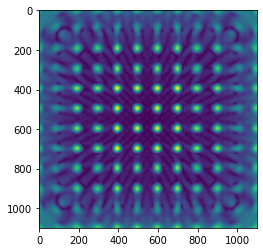

In [123]:
plt.imshow(data)